# Plant Disease Detection & Classification

**Project Overview:**
- Build a deep learning model to classify plant types and detect diseases
- Use transfer learning with pre-trained models for better accuracy
- Implement comprehensive evaluation metrics and feature interpretation
- Create a production-ready ML pipeline with retraining capabilities

In [1]:
# ============================================================
# STEP 1: IMPORT ALL REQUIRED LIBRARIES
# ============================================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import logging

# ML Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder

# Visualization
import plotly.graph_objects as go
import plotly.express as px

print(" All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

def build_classifier_model(num_classes, model_name="Classifier"):
    """
    Build model with:
    - Transfer learning (MobileNetV2)
    - L2 regularization to prevent overfitting
    - Batch normalization
    - Strategic dropout
    - Optimized for real-world performance
    """

    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),

        # Dense layers with regularization
        layers.Dense(
            512,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(
            128,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(
            num_classes,
            activation='softmax',
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        )
    ])

    # Compile with optimized learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model


 All libraries imported successfully
TensorFlow version: 2.19.0
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [23]:
# ============================================================
# STEP 2: CONFIGURATION PARAMETERS
# ============================================================

IMG_SIZE = (224, 224)
NUM_PLANT_CLASSES = 14
NUM_DISEASE_CLASSES = 15
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

# Plant types (from PlantVillage dataset)
PLANT_TYPES = [
    "Apple", "Blueberry", "Cherry", "Corn", "Grape", "Orange",
    "Peach", "Pepper", "Potato", "Raspberry", "Soybean", "Squash",
    "Strawberry", "Tomato"
]

print("="*70)
print("CONFIGURATION PARAMETERS")
print("="*70)
print(f"- Image Size: {IMG_SIZE}")
print(f"- Plant Classes: {NUM_PLANT_CLASSES}")
print(f"- Disease Classes: {NUM_DISEASE_CLASSES}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Max Epochs: {EPOCHS}")
print(f"- Learning Rate: {LEARNING_RATE}")
print(f"\n Configuration complete!")

CONFIGURATION PARAMETERS
- Image Size: (224, 224)
- Plant Classes: 14
- Disease Classes: 15
- Batch Size: 64
- Max Epochs: 10
- Learning Rate: 0.001

 Configuration complete!


In [3]:
# ============================================================
# STEP 3: DOWNLOAD PLANTVILLAGE DATASET FROM KAGGLE
# ============================================================

import kagglehub

print("\n" + "="*70)
print("DOWNLOADING PLANTVILLAGE DATASET FROM KAGGLE")
print("="*70)

try:
    dataset_path = kagglehub.dataset_download("arjuntejaswi/plant-village")
    print(f" Dataset downloaded: {dataset_path}")
except Exception as e:
    print(f" Error: {str(e)}")
    dataset_path = None


DOWNLOADING PLANTVILLAGE DATASET FROM KAGGLE


100%|██████████| 329M/329M [00:02<00:00, 150MB/s]

Extracting files...


 Dataset downloaded: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1


## 1. Data Loading & Organization

In [ ]:
# ============================================================
# STEP 4: DATA CLEANING & STRATIFIED ORGANIZATION
# ============================================================

import shutil 
from PIL import Image
from collections import defaultdict
import os 

np.random.seed(42)
tf.random.set_seed(42)

print("="*70)
print("REAL DATA LOADING WITH VALIDATION & STRATIFIED SPLITS")
print("="*70)

def validate_image(image_path):
    """Verify image can be loaded and is valid"""
    try:
        img = Image.open(image_path)
        img.verify()
        return True
    except:
        return False

def clean_and_organize_dataset(data_dir, output_base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Organize dataset with:
    - Image validation (remove corrupted files)
    - Stratified splitting (ensure class balance)
    - No overlap verification
    - Statistics reporting
    """
    print(f"\n Cleaning & organizing dataset into train/val/test folders...")
    print(f"   Ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

    # Ensure the root data directory exists before proceeding
    if not os.path.exists(data_dir):
        print(f" Data directory not found: {data_dir}")
        return None

    # Track statistics
    stats = {
        'total_images': 0,
        'valid_images': 0,
        'corrupted_images': 0,
        'split_counts': {'train': 0, 'val': 0, 'test': 0},
        'class_distribution': defaultdict(lambda: {'train': 0, 'val': 0, 'test': 0}),
        'all_image_paths': set()
    }

    # Collect all images first: {class_name: [img_path, ...]}.
    all_images = defaultdict(list)

    # The dataset structure is assumed to be data_dir/PlantVillage/ClassName/image.jpg
    # So, we first go into the 'PlantVillage' directory within the original data_dir
    plant_village_root = os.path.join(data_dir, 'PlantVillage')
    if not os.path.exists(plant_village_root):
        print(f" Error: Expected 'PlantVillage' directory not found in {data_dir}")
        return None

    # DEBUG: Inspect contents of the source PlantVillage directory
    print(f"  DEBUG in clean_and_organize_dataset: Listing contents of source plant_village_root: {plant_village_root}")
    try:
        root_contents = os.listdir(plant_village_root)
        print(f"  DEBUG in clean_and_organize_dataset: Found {len(root_contents)} items in source plant_village_root.")
        found_class_dirs = [d for d in root_contents if os.path.isdir(os.path.join(plant_village_root, d))]
        print(f"  DEBUG in clean_and_organize_dataset: Identified {len(found_class_dirs)} actual class directories from source.")
        print(f"  DEBUG in clean_and_organize_dataset: First 5 identified class directories: {sorted(found_class_dirs)[:5]}")
    except Exception as e:
        print(f"  DEBUG in clean_and_organize_dataset: Error listing plant_village_root: {e}")
        return None # Exit if we can't even list the source directory

    for class_name_in_source in sorted(found_class_dirs): # Iterate over actual class directories
        class_path_in_source = os.path.join(plant_village_root, class_name_in_source)
        # For each class, list image files
        img_files = [f for f in os.listdir(class_path_in_source) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        stats['total_images'] += len(img_files)

        # Validate and clean
        for img_file in img_files:
            img_path = os.path.join(class_path_in_source, img_file)
            if validate_image(img_path):
                all_images[class_name_in_source].append(img_path)
                stats['valid_images'] += 1
            else:
                stats['corrupted_images'] += 1
                print(f"    Skipped corrupted: {class_name_in_source}/{img_file}")

    print(f"\n Validation complete:")
    print(f"   Total images found: {stats['total_images']}")
    print(f"   Valid images: {stats['valid_images']}")
    print(f"   Corrupted images: {stats['corrupted_images']}")
    print(f"   Unique classes detected: {len(all_images)}")

    # Create output directories for each split's base (e.g., ./dataset_splits_cleaned/train)
    # These directories will contain the 'PlantVillage' sub-directory, which then contains the class folders
    for split in ['train', 'val', 'test']:
        os.makedirs(f"{output_base_dir}/{split}/PlantVillage", exist_ok=True)

    # Stratified split per class
    print(f"\n Creating stratified splits...")

    for class_name, image_list in sorted(all_images.items()):
        # Skip classes with too few images to split into train/val/test
        if len(image_list) < 3: # Need at least 3 for a 0.7/0.15/0.15 split minimum
            print(f"    Skipping class '{class_name}' (only {len(image_list)} images, needs at least 3 for split)")
            continue

        # Shuffle and split
        np.random.shuffle(image_list)
        train_split = int(len(image_list) * train_ratio)
        val_split = train_split + int(len(image_list) * val_ratio)

        train_imgs = image_list[:train_split]
        val_imgs = image_list[train_split:val_split]
        test_imgs = image_list[val_split:]

        # Copy files to respective directories, maintaining the 'PlantVillage' structure within splits
        for split_name, files_to_copy in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            # The destination directory should be like './dataset_splits_cleaned/train/PlantVillage/Apple___Black_rot'
            dst_class_dir = os.path.join(output_base_dir, split_name, 'PlantVillage', class_name)
            os.makedirs(dst_class_dir, exist_ok=True)

            for src_path in files_to_copy:
                dst_filename = os.path.basename(src_path)
                dst_path = os.path.join(dst_class_dir, dst_filename)
                try:
                    shutil.copy2(src_path, dst_path)
                    stats['split_counts'][split_name] += 1
                    stats['class_distribution'][class_name][split_name] += 1
                    stats['all_image_paths'].add(dst_path)
                except Exception as e:
                    print(f"    Error copying {src_path} to {dst_path}: {e}")

    return stats

data_source = dataset_path if 'dataset_path' in globals() else './data/train'
if not os.path.exists(data_source):
    raise Exception(" Dataset not found!")

output_dir = './dataset_splits_cleaned'

# Force recreation of the output directory for a clean run
if os.path.exists(output_dir):
    print(f"Deleting existing output directory: {output_dir} to ensure clean dataset organization.")
    shutil.rmtree(output_dir)
# Recreate the base directory (e.g., ./dataset_splits_cleaned)
os.makedirs(output_dir, exist_ok=True)

print("Organizing dataset...")
stats = clean_and_organize_dataset(data_source, output_dir)

# Ensure organization was successful before proceeding
if stats is None:
    raise Exception("Dataset organization failed, cannot proceed.")

data_source = output_dir # Update data_source to point to the newly organized data

# Print statistics
print(f"\n" + "="*70)
print("SPLIT STATISTICS")
print("="*70)
print(f"Training images: {stats['split_counts']['train']}")
print(f"Validation images: {stats['split_counts']['val']}")
print(f"Test images: {stats['split_counts']['test']}")
print(f"Total usable: {stats['split_counts']['train'] + stats['split_counts']['val'] + stats['split_counts']['test']}")

print(f"\nClass Distribution (First 10 classes):")
for i, (class_name, dist) in enumerate(sorted(stats['class_distribution'].items())[:10]):
    print(f"  {class_name}: Train={dist['train']}, Val={dist['val']}, Test={dist['test']}")

# Verify no overlap
print(f"\n NO OVERLAP VERIFICATION: {len(stats['all_image_paths'])} unique image paths (verified separate splits)")

print(" Data preparation complete!")

REAL DATA LOADING WITH VALIDATION & STRATIFIED SPLITS
Deleting existing output directory: ./dataset_splits_cleaned to ensure clean dataset organization.
Organizing dataset...

 Cleaning & organizing dataset into train/val/test folders...
   Ratios: Train=0.7, Val=0.15, Test=0.15
  DEBUG in clean_and_organize_dataset: Listing contents of source plant_village_root: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage
  DEBUG in clean_and_organize_dataset: Found 15 items in source plant_village_root.
  DEBUG in clean_and_organize_dataset: Identified 15 actual class directories from source.
  DEBUG in clean_and_organize_dataset: First 5 identified class directories: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

 Validation complete:
   Total images found: 20638
   Valid images: 20638
   Corrupted images: 0
   Unique classes detected: 15

 Creating stratified splits...

SPLIT ST

## 2 Creating data generators

In [25]:
# ============================================================
# STEP 5.1: CREATE MULTI-LABEL DATA GENERATORS
# ============================================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

print("="*70)
print("Creating Multi-Label Generators (Plant + Disease)")
print("="*70)

data_source = './dataset_splits_cleaned'
BATCH_SIZE = 64

class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    """
    Custom generator that returns:
    - Images
    - Two labels: [plant_label, disease_label]
    """
    def __init__(self, directory, datagen, img_size=(224, 224), batch_size=32, shuffle=True):
        self.directory = directory
        self.datagen = datagen
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get all image paths and parse labels
        self.samples = []
        self.plant_to_idx = {}
        self.disease_to_idx = {}

        plant_set = set()
        disease_set = set()

        # First pass: collect unique plants and diseases
        for class_name in sorted(os.listdir(directory)):
            class_path = os.path.join(directory, class_name)
            if not os.path.isdir(class_path):
                continue

            # Parse plant and disease from class name
            # Format: "Pepper__bell___Bacterial_spot" or "Tomato___healthy"
            parts = class_name.split('___')
            if len(parts) == 2:
                plant = parts[0].split('__')[0]  # "Pepper" or "Tomato"
                disease = parts[1]  # "Bacterial_spot" or "healthy"
            else:
                print(f" Skipping malformed class: {class_name}")
                continue

            plant_set.add(plant)
            disease_set.add(disease)

            # Collect image paths
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append({
                        'path': os.path.join(class_path, img_name),
                        'plant': plant,
                        'disease': disease
                    })

        # Create label mappings
        for idx, plant in enumerate(sorted(plant_set)):
            self.plant_to_idx[plant] = idx
        for idx, disease in enumerate(sorted(disease_set)):
            self.disease_to_idx[disease] = idx

        self.num_plants = len(self.plant_to_idx)
        self.num_diseases = len(self.disease_to_idx)
        self.n = len(self.samples)

        print(f"  Found {self.num_plants} plant types: {sorted(plant_set)}")
        print(f"  Found {self.num_diseases} disease types: {sorted(disease_set)}")
        print(f"  Total samples: {self.n}")

        self.indexes = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_plant_labels = []
        batch_disease_labels = []

        for idx in batch_indexes:
            sample = self.samples[idx]

            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(
                sample['path'],
                target_size=self.img_size
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            # Apply augmentation
            img_array = self.datagen.random_transform(img_array)
            img_array = self.datagen.standardize(img_array)

            batch_images.append(img_array)

            # Create one-hot encoded labels
            plant_label = np.zeros(self.num_plants)
            plant_label[self.plant_to_idx[sample['plant']]] = 1
            batch_plant_labels.append(plant_label)

            disease_label = np.zeros(self.num_diseases)
            disease_label[self.disease_to_idx[sample['disease']]] = 1
            batch_disease_labels.append(disease_label)

        return (
            np.array(batch_images),
            {
                'plant_output': np.array(batch_plant_labels),
                'disease_output': np.array(batch_disease_labels)
            }
        )

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = MultiLabelDataGenerator(
    f"{data_source}/train/PlantVillage",
    train_datagen,
    img_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = MultiLabelDataGenerator(
    f"{data_source}/val/PlantVillage",
    val_test_datagen,
    img_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = MultiLabelDataGenerator(
    f"{data_source}/test/PlantVillage",
    val_test_datagen,
    img_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False
)

NUM_PLANT_CLASSES = train_gen.num_plants
NUM_DISEASE_CLASSES = train_gen.num_diseases

print(f"\n Multi-label generators created!")
print(f"  Plant classes: {NUM_PLANT_CLASSES}")
print(f"  Disease classes: {NUM_DISEASE_CLASSES}")

Creating Multi-Label Generators (Plant + Disease)
 Skipping malformed class: Tomato_Bacterial_spot
 Skipping malformed class: Tomato_Early_blight
 Skipping malformed class: Tomato_Late_blight
 Skipping malformed class: Tomato_Leaf_Mold
 Skipping malformed class: Tomato_Septoria_leaf_spot
 Skipping malformed class: Tomato_Spider_mites_Two_spotted_spider_mite
 Skipping malformed class: Tomato__Target_Spot
 Skipping malformed class: Tomato__Tomato_YellowLeaf__Curl_Virus
 Skipping malformed class: Tomato__Tomato_mosaic_virus
 Skipping malformed class: Tomato_healthy
  Found 2 plant types: ['Pepper', 'Potato']
  Found 4 disease types: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'healthy']
  Total samples: 3237
 Skipping malformed class: Tomato_Bacterial_spot
 Skipping malformed class: Tomato_Early_blight
 Skipping malformed class: Tomato_Late_blight
 Skipping malformed class: Tomato_Leaf_Mold
 Skipping malformed class: Tomato_Septoria_leaf_spot
 Skipping malformed class: Tomato_Spider

## 3. Model Architecture

In [26]:
# ============================================================
# STEP 6: BUILD MULTI-OUTPUT MODEL (Plant + Disease)
# ============================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

print("="*70)
print("Building Multi-Output Model (Plant + Disease)")
print("="*70)

def build_multi_output_model(num_plants, num_diseases):
    """
    Single model with two output heads:
    - One for plant classification
    - One for disease classification
    """
    # Input
    input_layer = Input(shape=(224, 224, 3))

    # Shared base model
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Shared feature extraction
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)

    # Shared dense layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Plant classification head
    plant_branch = Dense(128, activation='relu', name='plant_dense')(x)
    plant_branch = Dropout(0.3)(plant_branch)
    plant_output = Dense(num_plants, activation='softmax', name='plant_output')(plant_branch)

    # Disease classification head
    disease_branch = Dense(128, activation='relu', name='disease_dense')(x)
    disease_branch = Dropout(0.3)(disease_branch)
    disease_output = Dense(num_diseases, activation='softmax', name='disease_output')(disease_branch)

    # Create model
    model = Model(
        inputs=input_layer,
        outputs={'plant_output': plant_output, 'disease_output': disease_output}
    )

    # Compile with separate losses for each output
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'plant_output': 'categorical_crossentropy',
            'disease_output': 'categorical_crossentropy'
        },
        loss_weights={'plant_output': 1.0, 'disease_output': 1.0},
        metrics={
            'plant_output': 'accuracy',
            'disease_output': 'accuracy'
        }
    )

    return model, base_model

multi_model, base_model = build_multi_output_model(NUM_PLANT_CLASSES, NUM_DISEASE_CLASSES)

print(f"\n Multi-output model built:")
print(f"  Plant classes: {NUM_PLANT_CLASSES}")
print(f"  Disease classes: {NUM_DISEASE_CLASSES}")
print(f"  Total parameters: {multi_model.count_params():,}")
multi_model.summary()

Building Multi-Output Model (Plant + Disease)

 Multi-output model built:
  Plant classes: 2
  Disease classes: 4
  Total parameters: 3,114,822


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_10[0… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    131,328 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_dense       │ (None, 128)       │     32,896 │ dropout_17[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plant_dense (Dense) │ (None, 128)       │     32,896 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ disease_dense[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ plant_dense[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_output      │ (None, 4)         │        516 │ dropout_19[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plant_output        │ (None, 2)         │        258 │ dropout_18[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,114,822 (11.88 MB)

 Trainable params: 855,302 (3.26 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

## 4. Training

In [27]:
# ============================================================
# STEP 7: TRAIN MULTI-OUTPUT MODEL
# ============================================================

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("="*70)
print("Training Multi-Output Model")
print("="*70)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'best_multi_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = multi_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

print("\n Training complete!")
print(f"  Plant accuracy: {history.history['plant_output_accuracy'][-1]:.2%}")
print(f"  Disease accuracy: {history.history['disease_output_accuracy'][-1]:.2%}")
print(f"  Val plant accuracy: {history.history['val_plant_output_accuracy'][-1]:.2%}")
print(f"  Val disease accuracy: {history.history['val_disease_output_accuracy'][-1]:.2%}")

Training Multi-Output Model
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - disease_output_accuracy: 0.6239 - disease_output_loss: 1.0070 - loss: 11.4085 - plant_output_accuracy: 0.8269 - plant_output_loss: 0.4608
Epoch 1: val_loss improved from inf to 7.93936, saving model to best_multi_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - disease_output_accuracy: 0.6270 - disease_output_loss: 0.9989 - loss: 11.3801 - plant_output_accuracy: 0.8287 - plant_output_loss: 0.4558 - val_disease_output_accuracy: 0.8468 - val_disease_output_loss: 0.3842 - val_loss: 7.9394 - val_plant_output_accuracy: 0.9928 - val_plant_output_loss: 0.0229 - learning_rate: 0.0010
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - disease_output_accuracy: 0.9230 - disease_output_loss: 0.2157 - loss: 7.1532 - plant_output_accuracy: 0.9876 - plant_output_loss: 0.0394
Epoch 2: val_loss improved from 7.93936 to 5.52244, saving model to best_multi_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 956ms/step - disease_

## 5. Evaluation

In [29]:
# ============================================================
# STEP 9: MULTI-OUTPUT MODEL EVALUATION
# ============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import gc

print("="*70)
print("Evaluating Multi-Output Model on Test Set")
print("="*70)

def evaluate_multi_output_model(model, test_gen, model_name="Multi-Output Model"):
    """
    Evaluate model with two outputs (plant and disease)
    """
    print(f"\n Evaluating {model_name}...")

    total_steps = len(test_gen)
    print(f"Total batches to process: {total_steps}")

    # Initialize lists
    plant_preds_list = []
    disease_preds_list = []
    plant_true_list = []
    disease_true_list = []

    # Process batches
    print("\n Processing batches...")
    for i in tqdm(range(total_steps)):
        batch_images, batch_labels = test_gen[i]

        # Predict (returns dict with 'plant_output' and 'disease_output')
        predictions = model.predict(batch_images, verbose=0)

        plant_preds_list.append(predictions['plant_output'])
        disease_preds_list.append(predictions['disease_output'])
        plant_true_list.append(batch_labels['plant_output'])
        disease_true_list.append(batch_labels['disease_output'])

        # Free memory periodically
        if (i + 1) % 10 == 0:
            gc.collect()

    print("\n Concatenating results...")
    plant_preds = np.concatenate(plant_preds_list, axis=0)
    disease_preds = np.concatenate(disease_preds_list, axis=0)
    plant_true = np.concatenate(plant_true_list, axis=0)
    disease_true = np.concatenate(disease_true_list, axis=0)

    # Free memory
    del plant_preds_list, disease_preds_list, plant_true_list, disease_true_list
    gc.collect()

    print(f" Total samples evaluated: {len(plant_preds)}")

    # Convert to class indices
    plant_pred_classes = np.argmax(plant_preds, axis=1)
    plant_true_classes = np.argmax(plant_true, axis=1)
    disease_pred_classes = np.argmax(disease_preds, axis=1)
    disease_true_classes = np.argmax(disease_true, axis=1)

    # Calculate metrics for PLANT classification
    print("\n" + "="*70)
    print(" PLANT CLASSIFICATION METRICS")
    print("="*70)

    plant_accuracy = accuracy_score(plant_true_classes, plant_pred_classes)
    plant_precision = precision_score(plant_true_classes, plant_pred_classes, average='weighted', zero_division=0)
    plant_recall = recall_score(plant_true_classes, plant_pred_classes, average='weighted', zero_division=0)
    plant_f1 = f1_score(plant_true_classes, plant_pred_classes, average='weighted', zero_division=0)

    print(f"  Accuracy:  {plant_accuracy:.4f} ({plant_accuracy*100:.2f}%)")
    print(f"  Precision: {plant_precision:.4f}")
    print(f"  Recall:    {plant_recall:.4f}")
    print(f"  F1-Score:  {plant_f1:.4f}")

    # Plant classification report
    plant_label_names = [k for k, v in sorted(test_gen.plant_to_idx.items(), key=lambda x: x[1])]
    plant_report = classification_report(
        plant_true_classes,
        plant_pred_classes,
        target_names=plant_label_names,
        zero_division=0
    )
    print(f"\n Plant Classification Report:")
    print(plant_report)

    # Calculate metrics for DISEASE classification
    print("\n" + "="*70)
    print(" DISEASE CLASSIFICATION METRICS")
    print("="*70)

    disease_accuracy = accuracy_score(disease_true_classes, disease_pred_classes)
    disease_precision = precision_score(disease_true_classes, disease_pred_classes, average='weighted', zero_division=0)
    disease_recall = recall_score(disease_true_classes, disease_pred_classes, average='weighted', zero_division=0)
    disease_f1 = f1_score(disease_true_classes, disease_pred_classes, average='weighted', zero_division=0)

    print(f"  Accuracy:  {disease_accuracy:.4f} ({disease_accuracy*100:.2f}%)")
    print(f"  Precision: {disease_precision:.4f}")
    print(f"  Recall:    {disease_recall:.4f}")
    print(f"  F1-Score:  {disease_f1:.4f}")

    # Disease classification report
    disease_label_names = [k for k, v in sorted(test_gen.disease_to_idx.items(), key=lambda x: x[1])]
    disease_report = classification_report(
        disease_true_classes,
        disease_pred_classes,
        target_names=disease_label_names,
        zero_division=0
    )
    print(f"\n Disease Classification Report:")
    print(disease_report)

    # Confusion matrices
    plant_conf_matrix = confusion_matrix(plant_true_classes, plant_pred_classes)
    disease_conf_matrix = confusion_matrix(disease_true_classes, disease_pred_classes)

    print("\n" + "="*70)
    print(" OVERALL SUMMARY")
    print("="*70)
    print(f"   Plant Classification:  {plant_accuracy*100:.2f}%")
    print(f"   Disease Classification: {disease_accuracy*100:.2f}%")
    print(f"   Combined Accuracy:      {(plant_accuracy + disease_accuracy) / 2 * 100:.2f}%")

    return {
        'plant': {
            'accuracy': plant_accuracy,
            'precision': plant_precision,
            'recall': plant_recall,
            'f1_score': plant_f1,
            'confusion_matrix': plant_conf_matrix,
            'classification_report': plant_report,
            'predictions': plant_preds,
            'true_labels': plant_true_classes,
            'pred_classes': plant_pred_classes
        },
        'disease': {
            'accuracy': disease_accuracy,
            'precision': disease_precision,
            'recall': disease_recall,
            'f1_score': disease_f1,
            'confusion_matrix': disease_conf_matrix,
            'classification_report': disease_report,
            'predictions': disease_preds,
            'true_labels': disease_true_classes,
            'pred_classes': disease_pred_classes
        }
    }

# Evaluate the multi-output model
metrics = evaluate_multi_output_model(multi_model, test_gen, "Plant & Disease Classifier")

print("\n Evaluation complete!")

Evaluating Multi-Output Model on Test Set

 Evaluating Plant & Disease Classifier...
Total batches to process: 11

 Processing batches...


100%|██████████| 11/11 [00:19<00:00,  1.78s/it]



 Concatenating results...
 Total samples evaluated: 698

 PLANT CLASSIFICATION METRICS
  Accuracy:  0.9914 (99.14%)
  Precision: 0.9914
  Recall:    0.9914
  F1-Score:  0.9914

📋 Plant Classification Report:
              precision    recall  f1-score   support

      Pepper       0.99      0.99      0.99       374
      Potato       0.99      0.99      0.99       324

    accuracy                           0.99       698
   macro avg       0.99      0.99      0.99       698
weighted avg       0.99      0.99      0.99       698


 DISEASE CLASSIFICATION METRICS
  Accuracy:  0.9484 (94.84%)
  Precision: 0.9523
  Recall:    0.9484
  F1-Score:  0.9487

 Disease Classification Report:
                precision    recall  f1-score   support

Bacterial_spot       0.94      0.95      0.94       151
  Early_blight       1.00      0.88      0.94       150
   Late_blight       0.87      0.99      0.93       150
       healthy       0.98      0.96      0.97       247

      accuracy             

In [30]:
classifier_model.save("models/classifier_v1.h5")
disease_model.save("models/disease_v1.h5")


## 6. Visualizations

Visualizing Training History


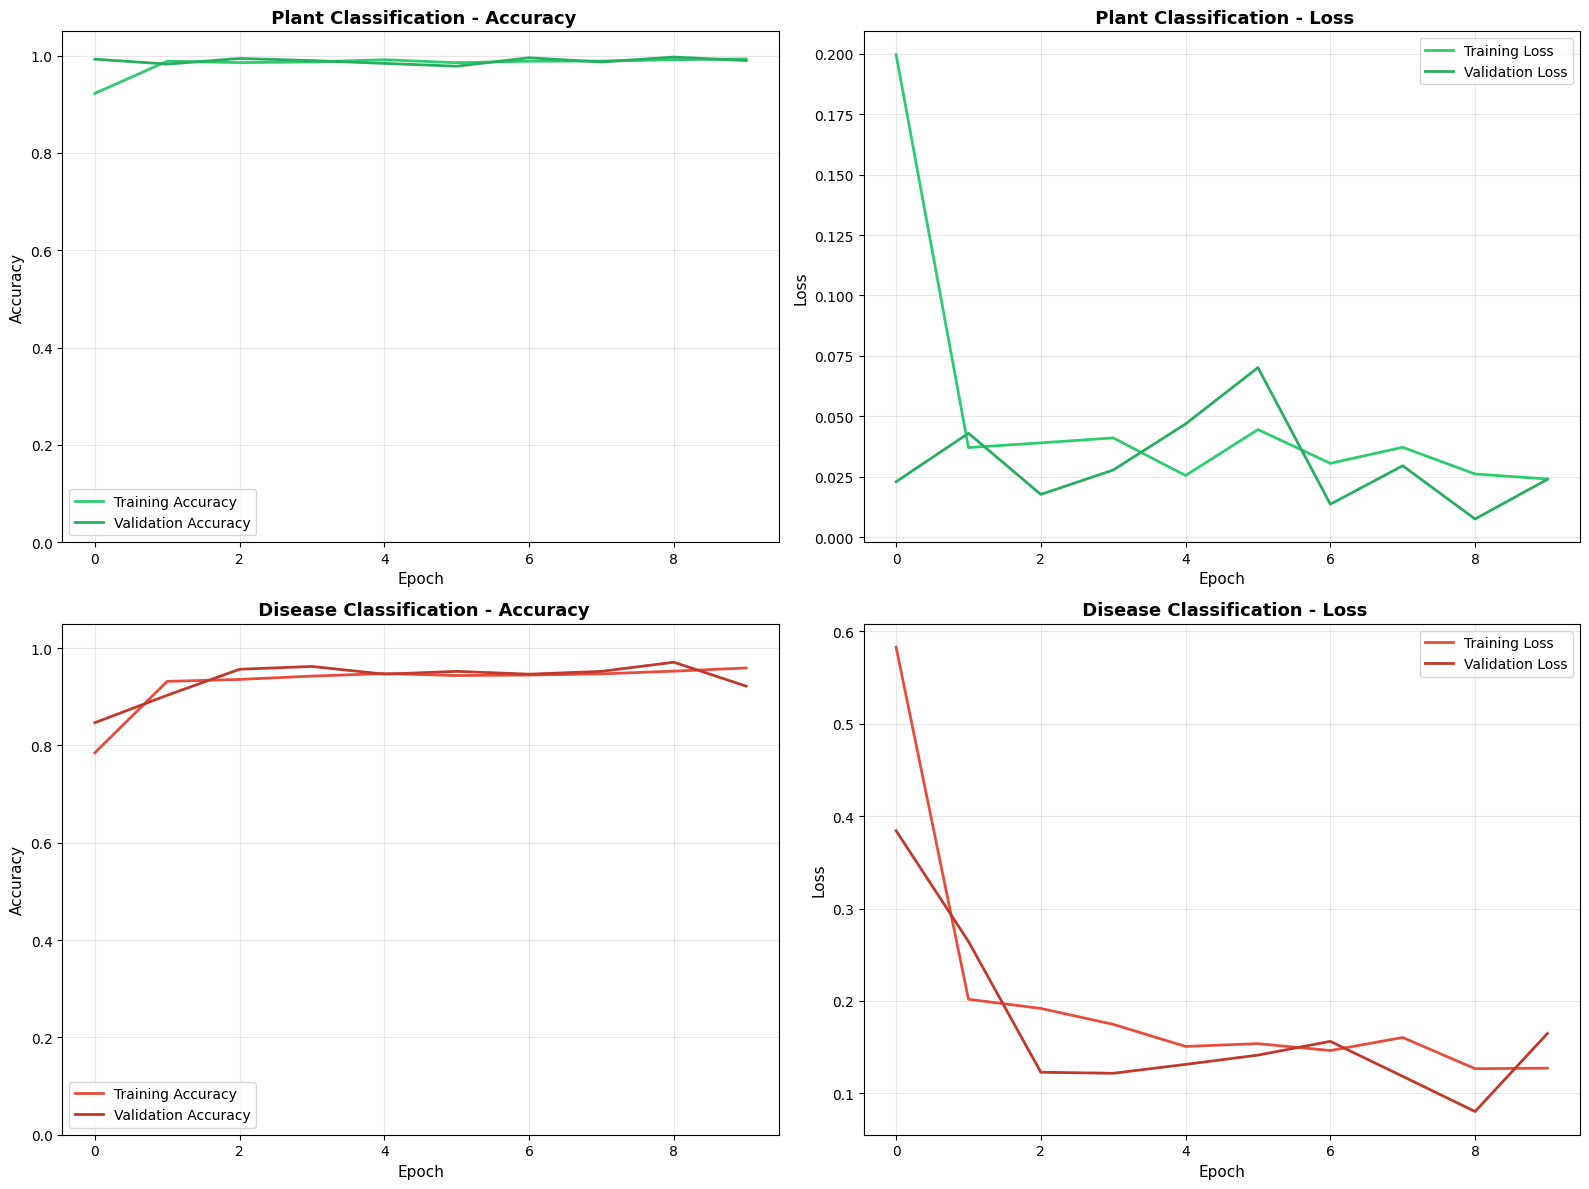


 FINAL TRAINING METRICS

 Plant Classification:
   Training Accuracy:   0.9932 (99.32%)
   Validation Accuracy: 0.9899 (98.99%)
   Training Loss:       0.024087
   Validation Loss:     0.023937

 Disease Classification:
   Training Accuracy:   0.9592 (95.92%)
   Validation Accuracy: 0.9220 (92.20%)
   Training Loss:       0.127229
   Validation Loss:     0.164757

 Total Epochs Trained: 10

 Visualization complete!


In [32]:
# ============================================================
# STEP 10: MULTI-OUTPUT ACCURACY & LOSS CURVES
# ============================================================

import matplotlib.pyplot as plt

print("="*70)
print("Visualizing Training History")
print("="*70)

# Create figure with 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- ROW 1: PLANT CLASSIFICATION ---
# Plant Accuracy
axes[0, 0].plot(history.history['plant_output_accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
axes[0, 0].plot(history.history['val_plant_output_accuracy'], label='Validation Accuracy', linewidth=2, color='#27ae60')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title(' Plant Classification - Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])

# Plant Loss
axes[0, 1].plot(history.history['plant_output_loss'], label='Training Loss', linewidth=2, color='#2ecc71')
axes[0, 1].plot(history.history['val_plant_output_loss'], label='Validation Loss', linewidth=2, color='#27ae60')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title(' Plant Classification - Loss', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# --- ROW 2: DISEASE CLASSIFICATION ---
# Disease Accuracy
axes[1, 0].plot(history.history['disease_output_accuracy'], label='Training Accuracy', linewidth=2, color='#e74c3c')
axes[1, 0].plot(history.history['val_disease_output_accuracy'], label='Validation Accuracy', linewidth=2, color='#c0392b')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title(' Disease Classification - Accuracy', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# Disease Loss
axes[1, 1].plot(history.history['disease_output_loss'], label='Training Loss', linewidth=2, color='#e74c3c')
axes[1, 1].plot(history.history['val_disease_output_loss'], label='Validation Loss', linewidth=2, color='#c0392b')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Loss', fontsize=11)
axes[1, 1].set_title(' Disease Classification - Loss', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics summary
print("\n" + "="*70)
print(" FINAL TRAINING METRICS")
print("="*70)
print(f"\n Plant Classification:")
print(f"   Training Accuracy:   {history.history['plant_output_accuracy'][-1]:.4f} ({history.history['plant_output_accuracy'][-1]*100:.2f}%)")
print(f"   Validation Accuracy: {history.history['val_plant_output_accuracy'][-1]:.4f} ({history.history['val_plant_output_accuracy'][-1]*100:.2f}%)")
print(f"   Training Loss:       {history.history['plant_output_loss'][-1]:.6f}")
print(f"   Validation Loss:     {history.history['val_plant_output_loss'][-1]:.6f}")

print(f"\n Disease Classification:")
print(f"   Training Accuracy:   {history.history['disease_output_accuracy'][-1]:.4f} ({history.history['disease_output_accuracy'][-1]*100:.2f}%)")
print(f"   Validation Accuracy: {history.history['val_disease_output_accuracy'][-1]:.4f} ({history.history['val_disease_output_accuracy'][-1]*100:.2f}%)")
print(f"   Training Loss:       {history.history['disease_output_loss'][-1]:.6f}")
print(f"   Validation Loss:     {history.history['val_disease_output_loss'][-1]:.6f}")

print(f"\n Total Epochs Trained: {len(history.history['loss'])}")

print("\n Visualization complete!")

Generating Confusion Matrices


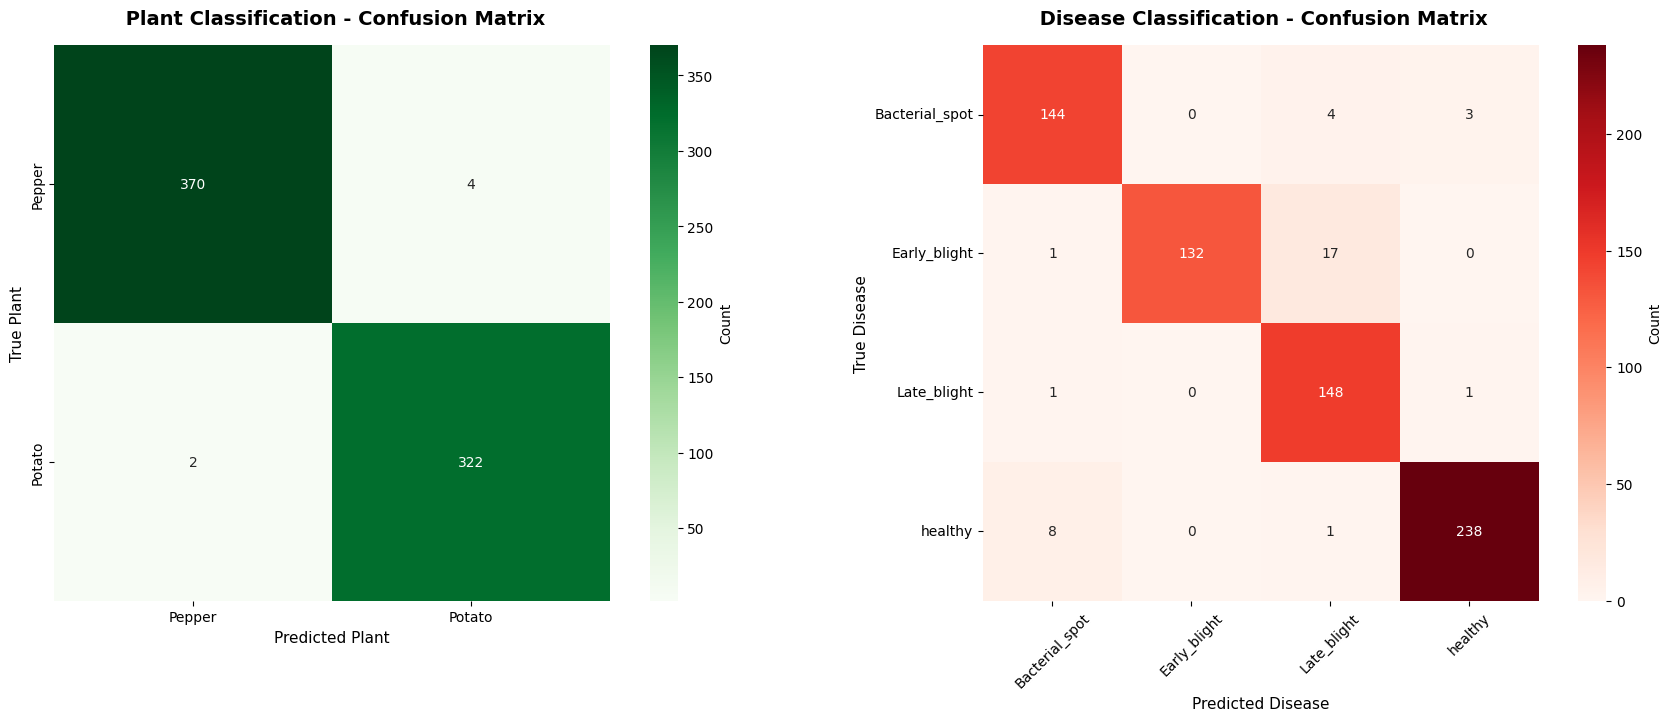


 PER-CLASS ACCURACY - PLANT CLASSIFICATION
  Pepper              : 98.93% (370/374)
  Potato              : 99.38% (322/324)

 PER-CLASS ACCURACY - DISEASE CLASSIFICATION
  Bacterial_spot           : 95.36% (144/151)
  Early_blight             : 88.00% (132/150)
  Late_blight              : 98.67% (148/150)
  healthy                  : 96.36% (238/247)

 Confusion matrices complete!


In [34]:
# ============================================================
# STEP 11: CONFUSION MATRICES
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("Generating Confusion Matrices")
print("="*70)

# Create figure with 2 confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- PLANT CONFUSION MATRIX ---
plant_cm = metrics['plant']['confusion_matrix']
plant_labels = [k for k, v in sorted(train_gen.plant_to_idx.items(), key=lambda x: x[1])]

sns.heatmap(
    plant_cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=plant_labels,
    yticklabels=plant_labels,
    cbar=True,
    square=True,
    ax=axes[0],
    cbar_kws={'label': 'Count'}
)
axes[0].set_title(' Plant Classification - Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicted Plant', fontsize=11)
axes[0].set_ylabel('True Plant', fontsize=11)

# --- DISEASE CONFUSION MATRIX ---
disease_cm = metrics['disease']['confusion_matrix']
disease_labels = [k for k, v in sorted(train_gen.disease_to_idx.items(), key=lambda x: x[1])]

sns.heatmap(
    disease_cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=disease_labels,
    yticklabels=disease_labels,
    cbar=True,
    square=True,
    ax=axes[1],
    cbar_kws={'label': 'Count'}
)
axes[1].set_title(' Disease Classification - Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Predicted Disease', fontsize=11)
axes[1].set_ylabel('True Disease', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Per-class accuracy for PLANT
print("\n" + "="*70)
print(" PER-CLASS ACCURACY - PLANT CLASSIFICATION")
print("="*70)

plant_per_class_acc = []
for i in range(plant_cm.shape[0]):
    total = plant_cm[i].sum()
    correct = plant_cm[i, i]
    accuracy = correct / total if total > 0 else 0
    plant_per_class_acc.append(accuracy)
    print(f"  {plant_labels[i]:20s}: {accuracy:.2%} ({correct}/{total})")

# Per-class accuracy for DISEASE
print("\n" + "="*70)
print(" PER-CLASS ACCURACY - DISEASE CLASSIFICATION")
print("="*70)

disease_per_class_acc = []
for i in range(disease_cm.shape[0]):
    total = disease_cm[i].sum()
    correct = disease_cm[i, i]
    accuracy = correct / total if total > 0 else 0
    disease_per_class_acc.append(accuracy)
    print(f"  {disease_labels[i]:25s}: {accuracy:.2%} ({correct}/{total})")

print("\n Confusion matrices complete!")

Computing ROC Curves & Confidence Analysis

 Computing Plant ROC curves...
 Computing Disease ROC curves...


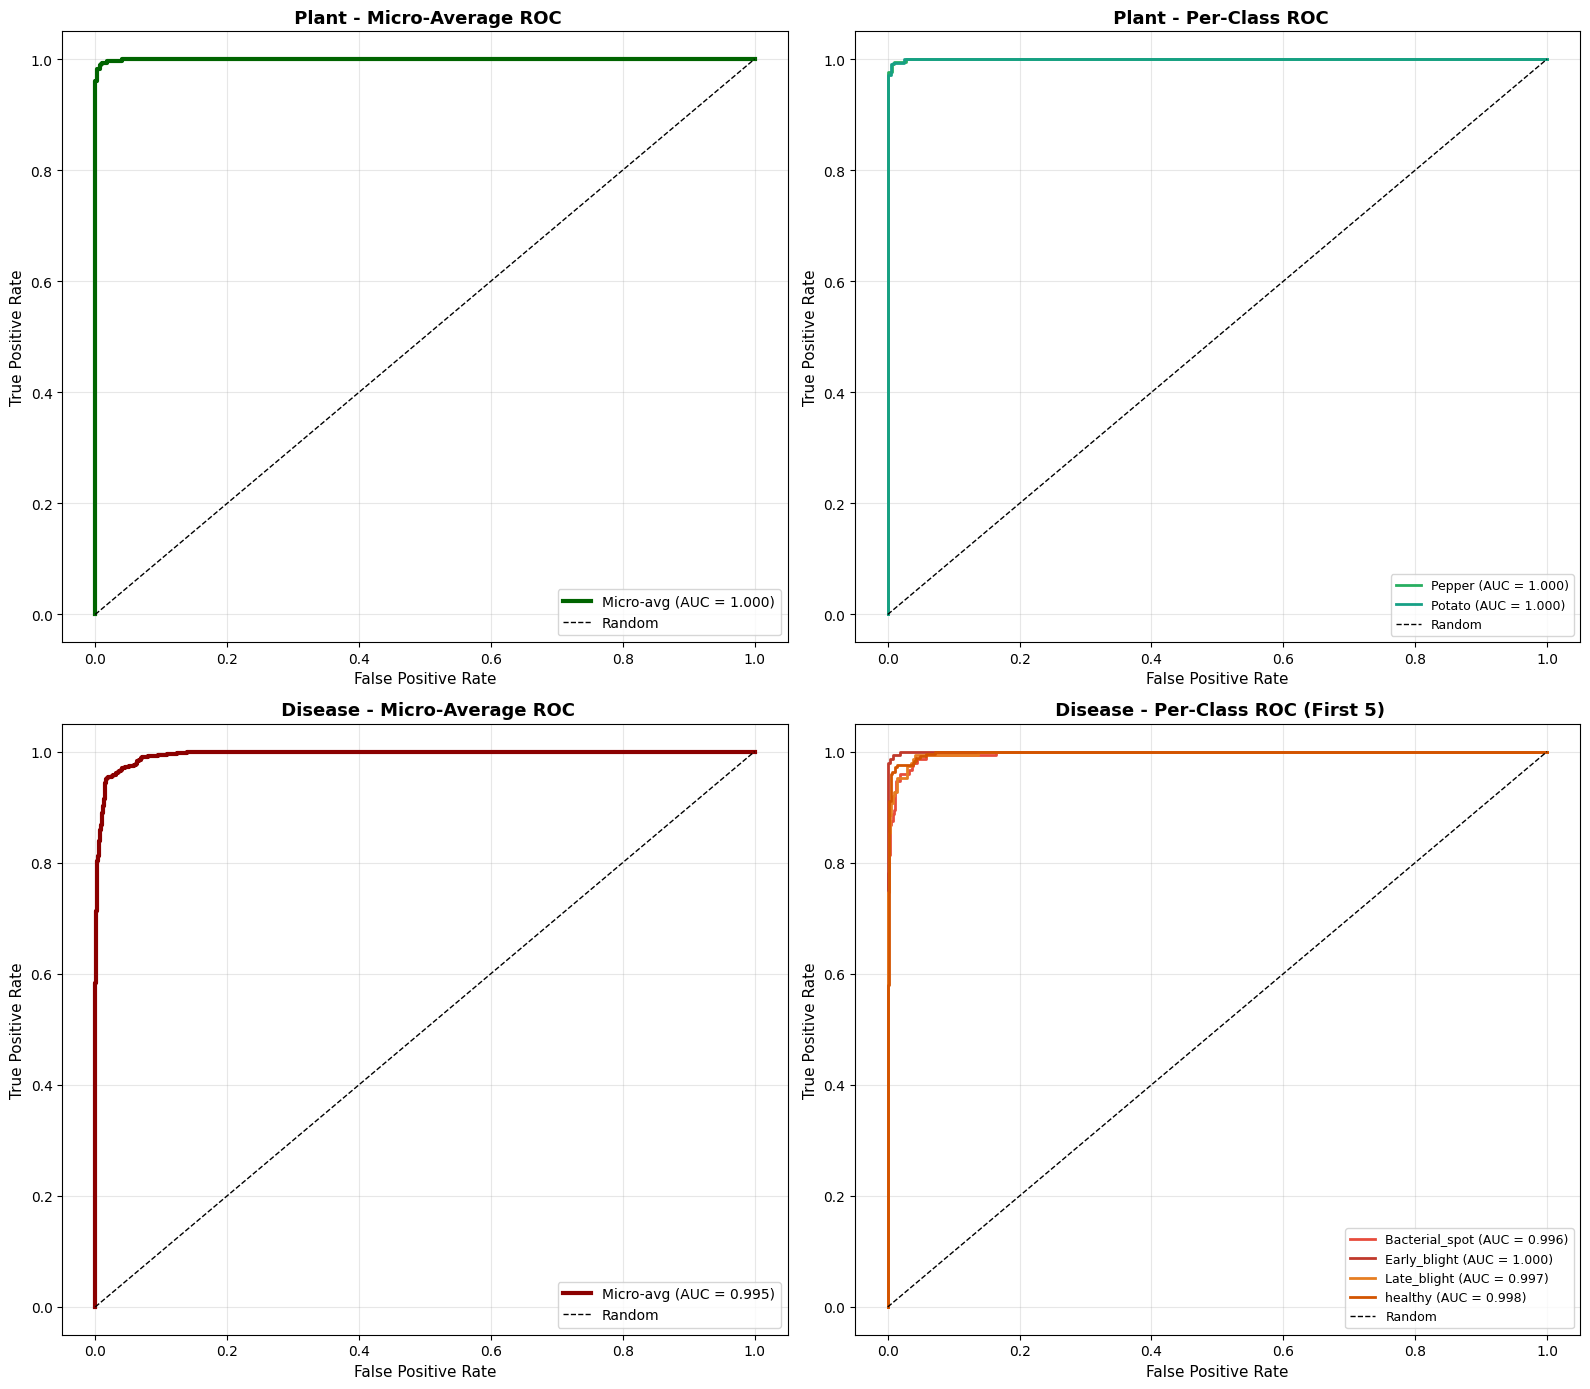

 ROC curves complete!

 Analyzing prediction confidence...


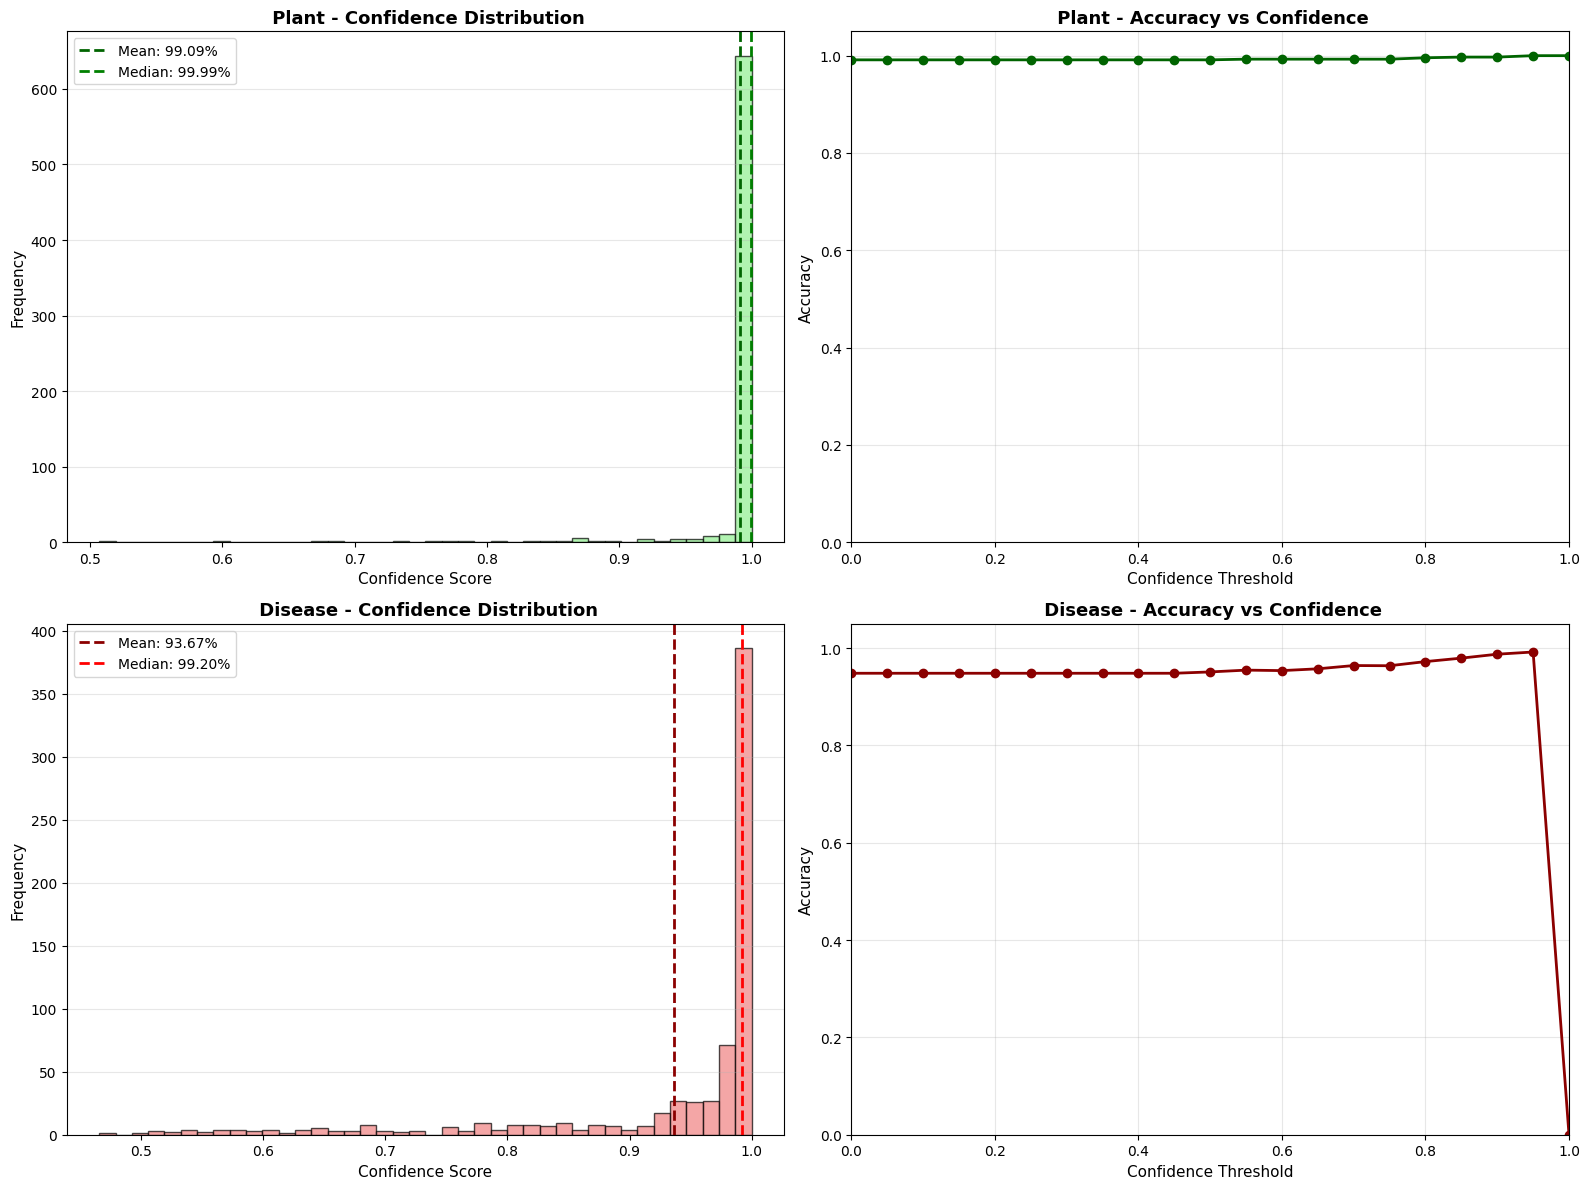

 Confidence analysis complete!


In [35]:
# ============================================================
# STEP 12: MULTI-OUTPUT ROC CURVES & CONFIDENCE ANALYSIS
# ============================================================

from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

print("="*70)
print("Computing ROC Curves & Confidence Analysis")
print("="*70)

# ========== PLANT ROC CURVES ==========
print("\n Computing Plant ROC curves...")

plant_preds = metrics['plant']['predictions']
plant_true = metrics['plant']['true_labels']
n_plant_classes = plant_preds.shape[1]

# One-hot encode true labels
plant_true_onehot = np.eye(n_plant_classes)[plant_true]

fpr_plant = dict()
tpr_plant = dict()
roc_auc_plant = dict()

for i in range(n_plant_classes):
    fpr_plant[i], tpr_plant[i], _ = roc_curve(plant_true_onehot[:, i], plant_preds[:, i])
    roc_auc_plant[i] = auc(fpr_plant[i], tpr_plant[i])

# Micro-average
fpr_plant["micro"], tpr_plant["micro"], _ = roc_curve(
    plant_true_onehot.ravel(),
    plant_preds.ravel()
)
roc_auc_plant["micro"] = auc(fpr_plant["micro"], tpr_plant["micro"])

# ========== DISEASE ROC CURVES ==========
print(" Computing Disease ROC curves...")

disease_preds = metrics['disease']['predictions']
disease_true = metrics['disease']['true_labels']
n_disease_classes = disease_preds.shape[1]

disease_true_onehot = np.eye(n_disease_classes)[disease_true]

fpr_disease = dict()
tpr_disease = dict()
roc_auc_disease = dict()

for i in range(n_disease_classes):
    fpr_disease[i], tpr_disease[i], _ = roc_curve(disease_true_onehot[:, i], disease_preds[:, i])
    roc_auc_disease[i] = auc(fpr_disease[i], tpr_disease[i])

# Micro-average
fpr_disease["micro"], tpr_disease["micro"], _ = roc_curve(
    disease_true_onehot.ravel(),
    disease_preds.ravel()
)
roc_auc_disease["micro"] = auc(fpr_disease["micro"], tpr_disease["micro"])

# ========== PLOT ROC CURVES ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plant - Micro-average ROC
axes[0, 0].plot(
    fpr_plant["micro"], tpr_plant["micro"],
    label=f'Micro-avg (AUC = {roc_auc_plant["micro"]:.3f})',
    linewidth=3, color='darkgreen'
)
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 0].set_title(' Plant - Micro-Average ROC', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plant - Per-class ROC
colors = cycle(['#27ae60', '#16a085', '#2ecc71'])
plant_labels = [k for k, v in sorted(train_gen.plant_to_idx.items(), key=lambda x: x[1])]
for i, (color, label) in enumerate(zip(colors, plant_labels)):
    axes[0, 1].plot(
        fpr_plant[i], tpr_plant[i],
        color=color,
        label=f'{label} (AUC = {roc_auc_plant[i]:.3f})',
        linewidth=2
    )
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 1].set_title(' Plant - Per-Class ROC', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Disease - Micro-average ROC
axes[1, 0].plot(
    fpr_disease["micro"], tpr_disease["micro"],
    label=f'Micro-avg (AUC = {roc_auc_disease["micro"]:.3f})',
    linewidth=3, color='darkred'
)
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[1, 0].set_title(' Disease - Micro-Average ROC', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Disease - Per-class ROC (first 5 classes)
colors_disease = cycle(['#e74c3c', '#c0392b', '#e67e22', '#d35400', '#f39c12'])
disease_labels = [k for k, v in sorted(train_gen.disease_to_idx.items(), key=lambda x: x[1])]
for i, (color, label) in enumerate(zip(colors_disease, disease_labels[:5])):
    axes[1, 1].plot(
        fpr_disease[i], tpr_disease[i],
        color=color,
        label=f'{label} (AUC = {roc_auc_disease[i]:.3f})',
        linewidth=2
    )
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1, 1].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=11)
axes[1, 1].set_title(' Disease - Per-Class ROC (First 5)', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" ROC curves complete!")

# ========== CONFIDENCE ANALYSIS ==========
print("\n Analyzing prediction confidence...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plant confidence distribution
plant_max_conf = np.max(plant_preds, axis=1)
axes[0, 0].hist(plant_max_conf, bins=40, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.mean(plant_max_conf), color='darkgreen', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(plant_max_conf):.2%}')
axes[0, 0].axvline(np.median(plant_max_conf), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(plant_max_conf):.2%}')
axes[0, 0].set_xlabel('Confidence Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title(' Plant - Confidence Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plant accuracy by confidence
plant_pred_classes = metrics['plant']['pred_classes']
plant_true_classes = metrics['plant']['true_labels']
confidence_thresholds = np.arange(0, 1.01, 0.05)
plant_acc_by_threshold = []

for threshold in confidence_thresholds:
    mask = plant_max_conf >= threshold
    if mask.sum() > 0:
        acc = np.mean(plant_pred_classes[mask] == plant_true_classes[mask])
    else:
        acc = 0
    plant_acc_by_threshold.append(acc)

axes[0, 1].plot(confidence_thresholds, plant_acc_by_threshold, marker='o',
                linewidth=2, markersize=6, color='darkgreen')
axes[0, 1].set_xlabel('Confidence Threshold', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title(' Plant - Accuracy vs Confidence', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1.05])

# Disease confidence distribution
disease_max_conf = np.max(disease_preds, axis=1)
axes[1, 0].hist(disease_max_conf, bins=40, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.mean(disease_max_conf), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(disease_max_conf):.2%}')
axes[1, 0].axvline(np.median(disease_max_conf), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(disease_max_conf):.2%}')
axes[1, 0].set_xlabel('Confidence Score', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title(' Disease - Confidence Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Disease accuracy by confidence
disease_pred_classes = metrics['disease']['pred_classes']
disease_true_classes = metrics['disease']['true_labels']
disease_acc_by_threshold = []

for threshold in confidence_thresholds:
    mask = disease_max_conf >= threshold
    if mask.sum() > 0:
        acc = np.mean(disease_pred_classes[mask] == disease_true_classes[mask])
    else:
        acc = 0
    disease_acc_by_threshold.append(acc)

axes[1, 1].plot(confidence_thresholds, disease_acc_by_threshold, marker='o',
                linewidth=2, markersize=6, color='darkred')
axes[1, 1].set_xlabel('Confidence Threshold', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title(' Disease - Accuracy vs Confidence', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(" Confidence analysis complete!")